In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [7]:
orders = pd.read_csv('/content/drive/MyDrive/DM/Data_Preparation/customer_supermarket_cleaned_orders.csv', sep='\t', index_col=0).reset_index()
orders['BasketDate'] = pd.to_datetime(orders.BasketDate, format='%Y/%m/%d %H:%M')

In [8]:
orders.head()

,BasketID,ProdID,BasketDate,CustomerCountry,Sale,CustomerID,ProdDescr,Qta,BasketDay,BasketMonth,BasketWeekOfYear,BasketYear,BasketWeekOfMonth,Tot
0,536365,21730,2010-12-01 08:26:00,United Kingdom,4.25,17850.0,GLASS STAR FROSTED T-LIGHT HOLDER,6,2,12,48,2010,1,25.50
1,536365,22752,2010-12-01 08:26:00,United Kingdom,7.65,17850.0,SET 7 BABUSHKA NESTING BOXES,2,2,12,48,2010,1,15.30
2,536365,71053,2010-12-01 08:26:00,United Kingdom,3.39,17850.0,WHITE METAL LANTERN,6,2,12,48,2010,1,20.34
3,536365,84029E,2010-12-01 08:26:00,United Kingdom,3.39,17850.0,RED WOOLLY HOTTIE WHITE HEART.,6,2,12,48,2010,1,20.34
4,536365,84029G,2010-12-01 08:26:00,United Kingdom,3.39,17850.0,KNITTED UNION FLAG HOT WATER BOTTLE,6,2,12,48,2010,1,20.34


##Creation of indicators 

###Indicators without entropies






In [9]:
# Number of baskets per customer ('NumBaskets')
def get_total_baskets(df,column_name,measure):
  res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).BasketID.nunique().reset_index()
  if measure == 'mean':
    res = res.groupby('CustomerID').BasketID.mean().to_frame(column_name+measure).reset_index()
  elif measure == 'stddev':
    res = res.groupby('CustomerID').BasketID.mean().to_frame(column_name+measure).reset_index()
  return res

# Number of distinct products per customer ('NumProducts')
def get_total_distinct_products(df,column_name,measure):
  res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).ProdID.nunique().reset_index()
  res = res.groupby('CustomerID').ProdID.mean().to_frame(column_name+measure).reset_index()
  return res

# Maximum number of items in a basket per customer ('MaxProd')
def get_max_basket_size(df,column_name):
  res = df.groupby(['CustomerID', 'BasketID']).Qta.sum().reset_index()
  res = res.groupby('CustomerID').Qta.max().to_frame(column_name).reset_index()
  return res

# Avg/Std basket size (in number of distinct products) per customer ('BasketSize_')
def get_basket_size_stat(df, column_name, measure):
  res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).ProdID.count().reset_index()
  if measure == 'mean':
    res = res.groupby('CustomerID').ProdID.mean().to_frame(column_name+measure).reset_index()
  elif measure == 'stddev':
    res = res.groupby('CustomerID').ProdID.std().to_frame(column_name+measure).reset_index()
  return res

# Avg/Std basket 'Qta' per customer ('BasketTotSize_')
def get_basket_total_size_stat(df, column_name, measure):
  if measure == 'mean':
    res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).Qta.sum().reset_index()
  elif measure == 'stddev':
    res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).Qta.std().reset_index()
  res = res.groupby('CustomerID').Qta.mean().to_frame(column_name+measure).reset_index()
  return res

# Avg/Std basket 'Tot' per customer ('BasketSaleSize_')
def get_basket_tot_stat(df, column_name):
  res = df.groupby(['CustomerID']).Tot.sum().to_frame(column_name).reset_index()
  return res

# Avg/Std basket 'Sale' per customer ('BasketSaleSize_')
def get_basket_sale_stat(df, column_name, measure):
  if measure == 'mean':
    res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).Sale.sum().reset_index()
  elif measure == 'stddev':
    res = df.groupby(['CustomerID', "BasketMonth", "BasketYear"]).Sale.std().reset_index()
  res = res.groupby('CustomerID').Sale.mean().to_frame(column_name+measure).reset_index()
  return res

In [10]:
data = get_total_baskets(orders, 'NumBaskets_','mean')

res = get_total_baskets(orders, 'NumBaskets_','stddev')

res = get_total_distinct_products(orders,'DistinticProducts_','mean')
data['DistinticProducts_mean'] = res['DistinticProducts_mean']

res = get_max_basket_size(orders,'MaxProd')
data['MaxProd'] = res['MaxProd']

res = get_basket_total_size_stat(orders, 'BasketTotSize_', 'mean')
data['Qta_mean'] = res['BasketTotSize_mean']

res = get_basket_total_size_stat(orders, 'BasketTotSize_', 'stddev')
data['Qta_stddev'] = res['BasketTotSize_stddev']

res = get_basket_sale_stat(orders, 'BasketSale_', 'mean')
data['Sale_mean'] = res['BasketSale_mean']

res = get_basket_sale_stat(orders, 'BasketSale_', 'stddev')
data['Sale_stddev'] = res['BasketSale_stddev']

###Indicators with entropies

In [11]:
from pandas.core.algorithms import value_counts 
from scipy.stats import entropy
import math

def apply_entropy(values, thresholds):
  # Discretize
  size = len(thresholds)
  classes_count = np.zeros(size+1)

  for v in values:
    for (i, t) in enumerate(thresholds):
      if v <= t:
        classes_count[i] += 1
        break
    
    if v > thresholds[size-1]:
      classes_count[size] += 1

  assert(sum(classes_count) == len(values))
  return entropy(classes_count, base=2) / math.log2(size+1)

def column_entropy(df, column_name, new_column, entropy_f):
  serie = df.groupby(["CustomerID", "BasketMonth", "BasketYear"]).agg({column_name: entropy_f})[column_name].to_frame(new_column).reset_index()
  serie = serie.groupby(["CustomerID"])[new_column].mean().reset_index()
  return serie

array([ 2., 10.])

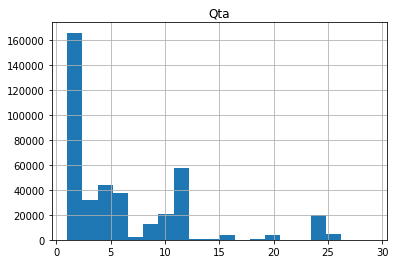

In [13]:
orders.hist(column=["Qta"], bins=20)
np.quantile(orders.Qta, [0.25, 0.75])

array([1.25, 3.75])

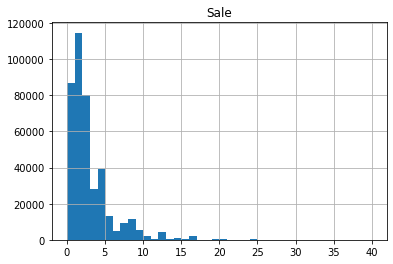

In [14]:
orders.hist(column=["Sale"], bins=40)
np.quantile(orders.Sale, [0.25, 0.75])

In [15]:
def qta_entropy(x):
  return apply_entropy(x, np.quantile(orders.Qta, [0.25, 0.75]))
data['Qta_entropy'] = column_entropy(orders, "Qta", "Qta_entropy", qta_entropy)['Qta_entropy']

In [16]:
def sale_entropy(x):
  return apply_entropy(x, np.quantile(orders.Sale, [0.25, 0.75]))
data['Sale_entropy'] = column_entropy(orders, "Sale", "Sale_entropy", sale_entropy)['Sale_entropy']

In [17]:
data.drop(columns=["CustomerID"], inplace=True)
data.head()

,NumBaskets_mean,DistinticProducts_mean,MaxProd,Qta_mean,Qta_stddev,Sale_mean,Sale_stddev,Qta_entropy,Sale_entropy
0,1.00,23.285714,496,253.428571,6.232782,60.191429,1.995065,0.633216,0.894589
1,1.00,2.000000,96,46.666667,0.000000,1.300000,0.000000,0.000000,0.000000
2,1.00,66.000000,530,530.000000,5.383650,265.200000,5.368290,0.897608,0.934952
3,1.00,16.000000,196,196.000000,3.492850,25.300000,0.578756,0.342951,0.623800
4,1.75,16.250000,125,131.500000,4.222667,78.452500,2.847938,0.745044,0.844006


In [18]:
data.describe()

,NumBaskets_mean,DistinticProducts_mean,MaxProd,Qta_mean,Qta_stddev,Sale_mean,Sale_stddev,Qta_entropy,Sale_entropy
count,4172.00000,4172.000000,4172.000000,4172.000000,4094.000000,4172.000000,4094.000000,4172.000000,4172.000000
mean,1.18943,24.164120,213.343960,171.981604,4.901823,70.381229,2.349998,0.617789,0.734914
std,0.72422,24.127742,196.997079,177.667585,2.062046,93.672921,1.238052,0.243598,0.242647
min,1.00000,1.000000,1.000000,1.000000,0.000000,0.290000,0.000000,0.000000,0.000000
25%,1.00000,10.000000,85.000000,72.950000,3.501820,26.981875,1.555874,0.511851,0.628855
50%,1.00000,18.000000,163.000000,131.000000,5.041133,51.984000,2.242077,0.656430,0.813859
75%,1.20000,30.931818,281.000000,223.270833,6.316770,92.295962,2.985299,0.797375,0.909909
max,34.00000,537.000000,2519.000000,3614.846154,12.727922,4011.780000,12.503333,1.000000,1.000000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NumBaskets_mean         4172 non-null   float64
 1   DistinticProducts_mean  4172 non-null   float64
 2   MaxProd                 4172 non-null   int64  
 3   Qta_mean                4172 non-null   float64
 4   Qta_stddev              4094 non-null   float64
 5   Sale_mean               4172 non-null   float64
 6   Sale_stddev             4094 non-null   float64
 7   Qta_entropy             4172 non-null   float64
 8   Sale_entropy            4172 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 293.5 KB


In [20]:
columns = [
    "NumBaskets_mean",
    "DistinticProducts_mean",
    "MaxProd",
    "Qta_mean",
    "Sale_mean",
    "Qta_entropy",
    "Sale_entropy"
]

##Data correlations

In [21]:
data[columns].corr("spearman")

,NumBaskets_mean,DistinticProducts_mean,MaxProd,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy
NumBaskets_mean,1.000000,0.251458,0.264273,0.273767,0.252184,0.059045,0.045900
DistinticProducts_mean,0.251458,1.000000,0.689588,0.751616,0.902050,0.381769,0.544296
MaxProd,0.264273,0.689588,1.000000,0.940186,0.521651,0.323002,0.294929
Qta_mean,0.273767,0.751616,0.940186,1.000000,0.571146,0.381023,0.385849
Sale_mean,0.252184,0.902050,0.521651,0.571146,1.000000,0.484734,0.601551
Qta_entropy,0.059045,0.381769,0.323002,0.381023,0.484734,1.000000,0.560262
Sale_entropy,0.045900,0.544296,0.294929,0.385849,0.601551,0.560262,1.000000


In [22]:
data[columns].corr("kendall")

,NumBaskets_mean,DistinticProducts_mean,MaxProd,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy
NumBaskets_mean,1.000000,0.196045,0.203468,0.213114,0.195760,0.046299,0.037732
DistinticProducts_mean,0.196045,1.000000,0.512496,0.573622,0.734316,0.263146,0.388693
MaxProd,0.203468,0.512496,1.000000,0.802573,0.365222,0.220031,0.201148
Qta_mean,0.213114,0.573622,0.802573,1.000000,0.403839,0.261828,0.267452
Sale_mean,0.195760,0.734316,0.365222,0.403839,1.000000,0.342019,0.432692
Qta_entropy,0.046299,0.263146,0.220031,0.261828,0.342019,1.000000,0.406452
Sale_entropy,0.037732,0.388693,0.201148,0.267452,0.432692,0.406452,1.000000


##Final dataset

In [23]:
final_data = data.drop(columns=['MaxProd', "Qta_stddev", "Sale_stddev"])

In [24]:
final_data.head()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy
0,1.00,23.285714,253.428571,60.191429,0.633216,0.894589
1,1.00,2.000000,46.666667,1.300000,0.000000,0.000000
2,1.00,66.000000,530.000000,265.200000,0.897608,0.934952
3,1.00,16.000000,196.000000,25.300000,0.342951,0.623800
4,1.75,16.250000,131.500000,78.452500,0.745044,0.844006


In [25]:
final_data.describe()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy
count,4172.00000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000
mean,1.18943,24.164120,171.981604,70.381229,0.617789,0.734914
std,0.72422,24.127742,177.667585,93.672921,0.243598,0.242647
min,1.00000,1.000000,1.000000,0.290000,0.000000,0.000000
25%,1.00000,10.000000,72.950000,26.981875,0.511851,0.628855
50%,1.00000,18.000000,131.000000,51.984000,0.656430,0.813859
75%,1.20000,30.931818,223.270833,92.295962,0.797375,0.909909
max,34.00000,537.000000,3614.846154,4011.780000,1.000000,1.000000


##Target label definition

In [26]:
def get_target(df):
  '''
  res = df.groupby(['CustomerID']).Tot.sum().to_frame("tot").reset_index()

  month_with_atleast_one_basket = df.groupby(["CustomerID", "BasketYear"]).BasketMonth.nunique().reset_index()
  month_with_atleast_one_basket = month_with_atleast_one_basket.groupby('CustomerID').BasketMonth.sum().to_frame("month_with_atleast_one_basket").reset_index()

  date_minimum = df.groupby(["CustomerID"]).BasketDate.min().reset_index()
  date_max = df.BasketDate.max()
  date_minimum["BasketDate"] = (date_max.year - date_minimum["BasketDate"].dt.year) * 12 + (date_max.month - date_minimum["BasketDate"].dt.month + 1)
  date_minimum["BasketDate"] = date_minimum["BasketDate"].astype(int)

  res["observation_period"] = date_minimum["BasketDate"]
  res["month_with_atleast_one_basket"] = month_with_atleast_one_basket["month_with_atleast_one_basket"]
  res["label"] = res["tot"] * res["month_with_atleast_one_basket"] / res["observation_period"]
  '''

  res = df.groupby(['CustomerID', 'BasketMonth', 'BasketYear']).Tot.sum().reset_index()
  res = res.groupby(['CustomerID']).Tot.mean().to_frame("tot_mean").reset_index()
  
  return res

In [27]:
target_eval = get_target(orders)

(0.0, 1000.0)

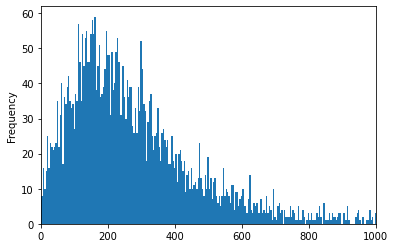

In [28]:
import matplotlib.pyplot as plt

target_eval['tot_mean'].plot.hist(bins = 2000)
plt.gca().set_xlim(0,1000)


In [29]:
target_eval.describe()

,CustomerID,tot_mean
count,4172.000000,4172.000000
mean,15298.341802,295.784427
std,1719.012081,310.279211
min,12347.000000,1.900000
25%,13820.500000,139.507500
50%,15297.500000,232.955000
75%,16777.250000,369.032500
max,18287.000000,8332.226000


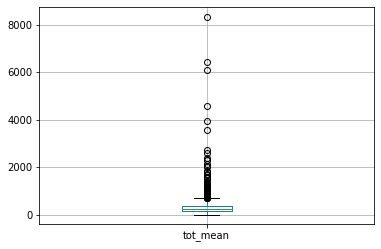

In [30]:
target_eval.boxplot(column='tot_mean')

In [31]:
res = []
for index in range(0,len(data)):
  if target_eval.iloc[index]['tot_mean'] <= 140:
    res.append(0)
  elif target_eval.iloc[index]['tot_mean'] <= 350:
    res.append(1)
  else:
    res.append(2)
final_data['label'] = res

In [32]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NumBaskets_mean         4172 non-null   float64
 1   DistinticProducts_mean  4172 non-null   float64
 2   Qta_mean                4172 non-null   float64
 3   Sale_mean               4172 non-null   float64
 4   Qta_entropy             4172 non-null   float64
 5   Sale_entropy            4172 non-null   float64
 6   label                   4172 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 228.3 KB


In [33]:
print(len(final_data[final_data['label'] == 0]))
print(len(final_data[final_data['label'] == 1]))
print(len(final_data[final_data['label'] == 2]))

1054
1960
1158


## Creation of the training and test sets

In [34]:
label_np = final_data.label.values
for train_indices, test_indices in StratifiedKFold(n_splits = 5, shuffle=True).split(label_np, label_np):
                training_set = final_data.iloc[train_indices]
                test_set = final_data.iloc[test_indices]
                break;

print(len(training_set))
print(len(test_set))

3337
835


In [ ]:
#training_set.to_csv('/content/drive/MyDrive/DM/Classification/classification_training_tot.csv')
#test_set.to_csv('/content/drive/MyDrive/DM/Classification/classification_test_tot.csv')

In [ ]:
for column in training_set.columns:
  training_set.boxplot(column=column)
  plt.savefig('/content/drive/MyDrive/DM/Classification/Plots/Raw/'+ column +'_hist.png')
  plt.show()

###Outliers removal

In [ ]:
clean_data = training_set.copy()
print(len(clean_data))
clean_data = clean_data[clean_data["NumBaskets_mean"] < 4]
clean_data = clean_data[clean_data["DistinticProducts_mean"] < 200]
clean_data = clean_data[clean_data["Qta_mean"] < 800]
clean_data = clean_data[clean_data["Sale_mean"] < 500]
print(len(clean_data))

In [ ]:
for column in clean_data.columns:
  clean_data.boxplot(column=column)
  plt.savefig('/content/drive/My Drive/DM/training_indicators/clean/'+ column +'_hist.pdf')
  plt.show()

##Standardization and Normalization

In [ ]:
normalized_data = clean_data.copy()
for to_normalize in normalized_data.columns:
  if to_normalize != 'label':
    mean = normalized_data[to_normalize].mean()
    std = normalized_data[to_normalize].std()
    normalized_data[to_normalize] = (normalized_data[to_normalize] - mean) / std
    test_set[to_normalize] = (test_set[to_normalize] - mean) / std

for to_normalize in normalized_data.columns:
  if to_normalize != 'label':
    min = normalized_data[to_normalize].min()
    max = normalized_data[to_normalize].max()
    normalized_data[to_normalize] = (normalized_data[to_normalize] - min) / (max - min)
    test_set[to_normalize] = (test_set[to_normalize] - min) / (max - min)



In [64]:
normalized_data.describe()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.057735,0.120153,0.207445,0.141933,0.501611,0.734843,1.017517
std,0.117653,0.107006,0.161356,0.120196,0.222969,0.241579,0.725659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.048138,0.091837,0.057230,0.388729,0.628275,0.000000
50%,0.000000,0.092643,0.165816,0.110778,0.544568,0.812482,1.000000
75%,0.070588,0.160763,0.281144,0.196253,0.639243,0.908394,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [66]:
normalized_data.corr("kendall")

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
NumBaskets_mean,1.000000,0.179896,0.201389,0.178980,0.055155,0.029493,0.233609
DistinticProducts_mean,0.179896,1.000000,0.567956,0.730378,0.263523,0.389881,0.609538
Qta_mean,0.201389,0.567956,1.000000,0.396266,0.263527,0.263350,0.700457
Sale_mean,0.178980,0.730378,0.396266,1.000000,0.271548,0.438699,0.572408
Qta_entropy,0.055155,0.263523,0.263527,0.271548,1.000000,0.294467,0.241280
Sale_entropy,0.029493,0.389881,0.263350,0.438699,0.294467,1.000000,0.352187
label,0.233609,0.609538,0.700457,0.572408,0.241280,0.352187,1.000000


In [ ]:
#normalized_data.to_csv('/content/drive/MyDrive/DM/Classification/normalized_data_classification_training_tot.csv')
#test_set.to_csv('/content/drive/MyDrive/DM/Classification/normalized_data_classification_test_tot.csv')